In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk
Child returned 0


rm -rf /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt && mkdir -p /shared/CSHL_data_processed/MD635
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt


Child returned 1
0.35 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt && mkdir -p /shared/CSHL_data_processed/MD635
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt


Child returned 1
0.34 seconds.
File does not exist: /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt
Child returned 0


rm -rf /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt && mkdir -p /shared/CSHL_data_processed/MD635
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt


Child returned 1
0.35 seconds.
File does not exist: /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt


In [3]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

xgboost is not loaded.

In [4]:
# structures_to_sample = all_known_structures

# negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

# margins_to_sample = [500] # (200: 100 um, 500: 250 um)
# surround_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
#                              for m in margins_to_sample
#                              for s in structures_to_sample 
#                              for surr_l in structures_to_sample + ['noclass'] 
#                              if surr_l != s]

# labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_labels_to_sample + ['noclass']

# Train Classifiers

In [4]:
classifier_settings

,model,margin,train_set_id,neg_composition,sample_weighting
classifier_id,,,,,
30,lr,500,20/21,neg_has_all_surround,NaN
31,lr,500,21/22,neg_has_all_surround,NaN
32,lr,500,20/22,neg_has_all_surround,NaN
33,gb1,500,20/21,neg_has_all_surround,NaN
34,gb1,500,21/22,neg_has_all_surround,NaN
35,gb1,500,20/22,neg_has_all_surround,NaN
36,gb1,500,23/24,neg_has_all_surround,NaN
37,lr,500,23/24,neg_has_all_surround,NaN
95,gb2,500,93,neg_has_all_surround,NaN


In [5]:
classifier_id = 37
classifier_properties = classifier_settings.loc[classifier_id]

margin = classifier_properties['margin']
model = classifier_properties['model']
sample_weighting = classifier_properties['sample_weighting']
neg_composition = classifier_properties['neg_composition']

In [6]:
# Determine which labels to load.

structures_to_sample = all_known_structures
negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

margins_to_sample = [margin] # (200: 100 um, 500: 250 um)
surround_positive_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample
                             if surr_l != s]
surround_noclass_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix='noclass') 
                             for m in margins_to_sample
                             for s in structures_to_sample]

if neg_composition == 'neg_has_everything_else':
    labels_to_sample = structures_to_sample + negative_labels_to_sample
elif neg_composition == 'neg_has_only_surround_noclass':
    labels_to_sample = structures_to_sample + surround_noclass_labels_to_sample + ['noclass']
elif neg_composition == 'neg_has_all_surround':
    labels_to_sample = structures_to_sample + surround_positive_labels_to_sample + surround_noclass_labels_to_sample + ['noclass']

In [7]:
# Load training dataset.

training_set_ids = map(int, str(classifier_properties['train_set_id']).split('/'))
training_features, training_addresses = load_datasets(training_set_ids, labels_to_sample=labels_to_sample)
# training_features, training_addresses = load_datasets(training_set_ids, labels_to_sample=labels_to_sample, 
#                                                       clf_rootdir=CELL_FEATURES_CLF_ROOTDIR)
    
assert set(training_addresses.keys()) == set(training_features.keys()), \
    'Training features and training addresses are not consistent.'

In [8]:
labels_found = training_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found 
                        if convert_to_original_name(l) in labels_found]) - {'noclass'}

In [9]:
for structure in structures_found:

    print structure
    
    #############################
    ## Define Positive Samples ##
    #############################
    
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    #############################
    ## Define Negative Samples ##
    #############################
    
#     if setting in [1, 3, 4, 5, 6, 7]:
    if neg_composition == 'neg_has_only_surround_noclass':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
    elif neg_composition == 'neg_has_all_surround':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
#     elif setting in [8,9,11]:
    elif neg_composition == 'neg_has_everything_else':
        neg_classes = [structure + '_negative']
    else:
        raise Exception('neg_composition %s is not recognized.' % neg_composition)

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
        
    ###########################
    ## Define Sample Weights ##
    ###########################
    
#     if setting == 9:
    if sample_weighting == 'weighted':
        neg_distances = np.concatenate([distances_to_structures[neg_class][structure] for neg_class in neg_classes])
            
        sample_weights_neg = np.ones((n_neg,))
        sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
        sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
    else:
        sample_weights = None
    
    ###########################################################################################

    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
#     n_train = len(train_labels0)
#     ri = np.random.choice(range(n_train), size=100, replace=False)
#     train_data = train_data0[ri]
#     train_labels = train_labels0[ri]
    
    ##################
    ## Define Model ##
    ##################
    
    if model == 'lr':
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
            
    elif model == 'lin_svc':
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)
        

    elif model == 'lin_svc_calib':
        
        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)
        
        
    elif model == 'xgb1':
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
    elif model == 'gb1':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    elif model == 'gb2':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    
    else:
        sys.stderr.write('Setting is not recognized.\n')
    
    t = time.time()    
    clf.fit(train_data, train_labels, sample_weight=sample_weights)
    sys.stderr.write('Fitting classifier: %.2f seconds\n' % (time.time() - t))
    
    clf_fp = DataManager.get_classifier_filepath(classifier_id=classifier_id, structure=structure)
    create_parent_dir_if_not_exists(clf_fp)
    joblib.dump(clf, clf_fp)
    
    upload_to_s3(clf_fp)

Tz


Fitting classifier: 1.13 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/Tz_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/Tz_clf_setting_37.dump


Child returned 0
0.42 seconds.


Sp5O


Fitting classifier: 2.07 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/Sp5O_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/Sp5O_clf_setting_37.dump


Child returned 0
0.37 seconds.


7n


Fitting classifier: 0.81 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/7n_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/7n_clf_setting_37.dump


Child returned 0
0.38 seconds.


DC


Fitting classifier: 2.57 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/DC_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/DC_clf_setting_37.dump


Child returned 0
0.42 seconds.


5N


Fitting classifier: 0.91 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/5N_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/5N_clf_setting_37.dump


Child returned 0
0.37 seconds.


RtTg


Fitting classifier: 2.33 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/RtTg_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/RtTg_clf_setting_37.dump


Child returned 0
0.36 seconds.


Pn


Fitting classifier: 1.75 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/Pn_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/Pn_clf_setting_37.dump


Child returned 0
0.37 seconds.


10N


Fitting classifier: 1.39 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/10N_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/10N_clf_setting_37.dump


Child returned 0
0.37 seconds.


LC


Fitting classifier: 0.90 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/LC_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/LC_clf_setting_37.dump


Child returned 0
0.42 seconds.


7N


Fitting classifier: 0.92 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/7N_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/7N_clf_setting_37.dump


Child returned 0
0.37 seconds.


Amb


Fitting classifier: 0.41 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/Amb_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/Amb_clf_setting_37.dump


Child returned 0
0.37 seconds.


12N


Fitting classifier: 1.45 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/12N_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/12N_clf_setting_37.dump


Child returned 0
0.42 seconds.


RMC


Fitting classifier: 0.92 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/RMC_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/RMC_clf_setting_37.dump


Child returned 0
0.37 seconds.


VCA


Fitting classifier: 2.27 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/VCA_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/VCA_clf_setting_37.dump


Child returned 0
0.37 seconds.


Sp5I


Fitting classifier: 2.48 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/Sp5I_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/Sp5I_clf_setting_37.dump


Child returned 0
0.42 seconds.


Sp5C


Fitting classifier: 1.90 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/Sp5C_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/Sp5C_clf_setting_37.dump


Child returned 0
0.37 seconds.


4N


Fitting classifier: 0.40 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/4N_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/4N_clf_setting_37.dump


Child returned 0
0.37 seconds.


AP


Fitting classifier: 0.59 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/AP_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/AP_clf_setting_37.dump


Child returned 0
0.42 seconds.


PBG


Fitting classifier: 0.64 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/PBG_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/PBG_clf_setting_37.dump


Child returned 0
0.37 seconds.


LRt


Fitting classifier: 0.74 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/LRt_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/LRt_clf_setting_37.dump


Child returned 0
0.37 seconds.


IC


Fitting classifier: 2.06 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/IC_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/IC_clf_setting_37.dump


Child returned 0
0.37 seconds.


VLL


Fitting classifier: 0.77 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/VLL_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/VLL_clf_setting_37.dump


Child returned 0
0.37 seconds.


VCP


Fitting classifier: 2.31 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/VCP_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/VCP_clf_setting_37.dump


Child returned 0
0.37 seconds.


SNC


Fitting classifier: 1.45 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/SNC_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/SNC_clf_setting_37.dump


Child returned 0
0.42 seconds.


6N


Fitting classifier: 0.37 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/6N_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/6N_clf_setting_37.dump


Child returned 0
0.37 seconds.


SNR


Fitting classifier: 1.74 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/SNR_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/SNR_clf_setting_37.dump


Child returned 0
0.37 seconds.


SC


Fitting classifier: 2.27 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/SC_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/SC_clf_setting_37.dump


Child returned 0
0.38 seconds.


3N


Fitting classifier: 0.89 seconds


aws s3 cp /shared/CSHL_classifiers/setting_37/classifiers/3N_clf_setting_37.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/3N_clf_setting_37.dump


Child returned 0
0.42 seconds.


# Load pre-computed classifiers, measure training accuracy

In [10]:
classifier_id = 37

In [11]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = DataManager.get_classifier_filepath(classifier_id=classifier_id, structure=structure)
    download_from_s3(clf_fp)
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('Classifier for %s is not found.\n' % structure)

rm -rf /shared/CSHL_classifiers/setting_37/classifiers/sp5_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/sp5_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/sp5_clf_setting_37.dump


Child returned 0
Child returned 1
0.38 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_37/classifiers/outerContour_clf_setting_37.dump && mkdir -p /shared/CSHL_classifiers/setting_37/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_37/classifiers/outerContour_clf_setting_37.dump /shared/CSHL_classifiers/setting_37/classifiers/outerContour_clf_setting_37.dump


Child returned 1
0.35 seconds.
Classifier for outerContour is not found.


In [12]:
margin = 500
neg_composition = 'neg_has_all_surround'

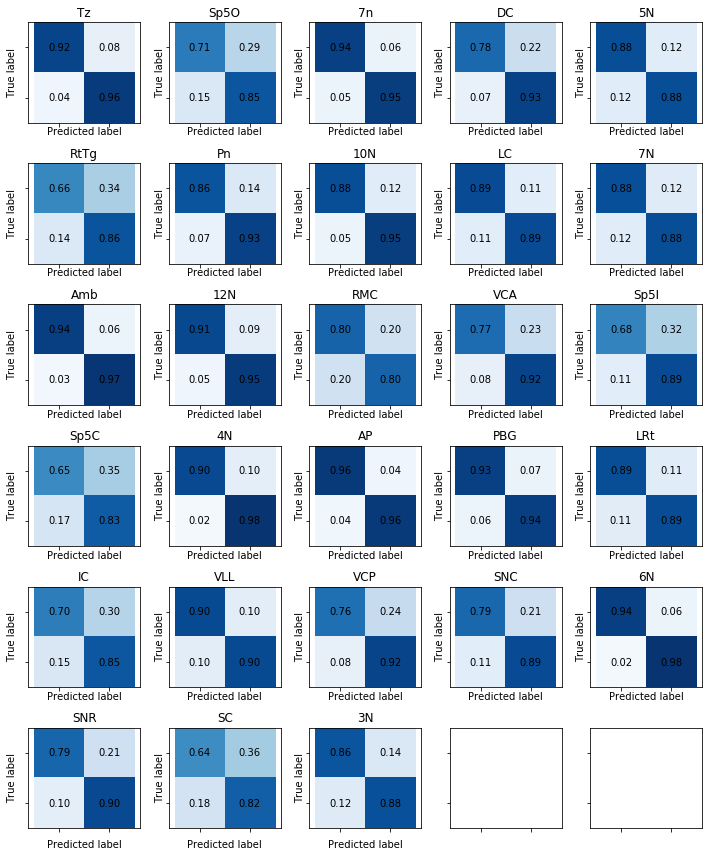

In [13]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
#     if setting in [1, 3, 4, 5, 6, 7]:
#         neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
#         neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]            
#         for surr_l in structures_found:
#             c = convert_to_surround_name(structure, margin=margin, suffix=surr_l)
#             if c in labels_found:
#                 neg_classes.append(c)
#     elif setting in [8,9,11]:
#         neg_classes = [structure + '_negative']
#     else:
#         sys.stderr.write('Setting is not recognized.\n')
#         raise

#     if setting in [1, 3, 4, 5, 6, 7]:
    if neg_composition == 'neg_has_only_surround_noclass':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
    elif neg_composition == 'neg_has_all_surround':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
#     elif setting in [8,9,11]:
    elif neg_composition == 'neg_has_everything_else':
        neg_classes = [structure + '_negative']
    else:
        raise Exception('Setting is not recognized.')
        
        
    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
#     neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(train_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s'% {'structure':structure},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [14]:
print 'training accuracy:', np.mean(acc_all_structures.values())

training accuracy: 0.882916909579


In [ ]:
# Visualize training patches (assume region-based addresses are provided)

In [32]:
sys.path.append(os.path.join(REPO_DIR, 'cells'))
from cell_utilities import *

In [46]:
def convert_region_based_addresses_to_grid_based_addresses(region_based_addresses):
    """
    Convert a list of region-based addresses (stack, section, region_index) to a list of grid-based addresses (stack, section, grid_index).
    """
    
    patch_size = 224
    patch_spacing = 56

    location_to_grid_cache = {}
    region_contours_cache = {}
    
    grid_based_addresses = []
    for st, sec, region_index in region_based_addresses:
        
        if (st, sec) not in region_contours_cache:
            region_contours_cache[(st, sec)] = load_cell_classifier_data(what='region_contours', ext='bp', stack=st, sec=sec)
        region_contours = region_contours_cache[(st, sec)]
        region_centroids = region_contours.mean(axis=1).astype(np.int)
        
        if st not in location_to_grid_cache:
            grid_to_location = grid_parameters_to_sample_locations(get_default_gridspec(stack=stack, patch_size=patch_size, stride=patch_spacing))
            location_to_grid_cache[st] = {tuple(loc): i for i, loc in enumerate(grid_to_location)}
        
        grid_index = location_to_grid_cache[st][tuple(region_centroids[region_index])]
        grid_based_addresses.append((st, sec, grid_index))
        
    return grid_based_addresses

In [ ]:
pool = Pool(NUM_CORES)
res = pool.map(convert_region_based_addresses_to_grid_based_addresses, training_addresses.values())
training_addresses_grid_based = dict(zip(training_addresses.keys(), res))
pool.close()
pool.join()

In [ ]:
training_addresses_grid_based = \
{label: convert_region_based_addresses_to_grid_based_addresses(addrs) 
 for label, addrs in training_addresses.iteritems()}

In [45]:
download_from_s3(DataManager.get_image_dir(stack=stack, resol='lossless', version='compressed'), is_dir=True)

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_compressed && mkdir -p /shared/CSHL_data_processed/MD594
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_compressed /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_compressed


Child returned 0
Child returned 0
45.38 seconds.


In [40]:
training_addresses_grid_based_to_display = \
convert_region_based_addresses_to_grid_based_addresses(training_addresses['12N'][:10])

In [ ]:
# Visualize training patches

patches = extract_patches_given_locations_multiple_sections(training_addresses_grid_based_to_display, 
                                                            location_or_grid_index='grid_index',
                                                            version='compressed')

# patches = extract_patches_given_locations_multiple_sections(training_addresses['12N'][:10], 
#                                                             location_or_grid_index='grid_index',
#                                                             version='compressed')
display_images_in_grids(patches, nc=10)

# patches = extract_patches_given_locations_multiple_sections(training_addresses['12N_surround'][:10], 
#                                                             location_or_grid_index='grid_index',
#                                                             version='compressed')
# display_images_in_grids(patches, nc=10)

In [34]:
def patch_boxes_overlay_on(bg, downscale_factor, locs, patch_size, colors=None, stack=None, sec=None):
    """
    Assume bg has the specified downscale_factor.
    """

    if bg == 'original':
        bg = imread(DataManager.get_image_filepath(stack=stack, section=sec, version='compressed'))[::downscale_factor, ::downscale_factor]
       
    # viz = bg.copy()
    viz = gray2rgb(bg).copy()
    # need copy() because of this bug http://stackoverflow.com/a/31316516
    
    half_size = patch_size/2/downscale_factor
    if isinstance(locs[0], list):
        if colors is None:
            colors = random_colors(len(locs))
        for i, locs_oneColor in enumerate(locs):
            for x, y in locs_oneColor:
                x = x / downscale_factor
                y = y / downscale_factor
                cv2.rectangle(viz, (x-half_size, y-half_size), (x+half_size, y+half_size), colors[i], 2)
    else:
        if colors is None:
            colors = (255,0,0)
        for x, y in locs:
            x = x / downscale_factor
            y = y / downscale_factor
            cv2.rectangle(viz, (x-half_size, y-half_size), (x+half_size, y+half_size), colors, 2)
            
    return viz

In [35]:
# Visualize a patch in context

patch_size, stride, _, _ = get_default_gridspec('MD589')
grid_locations = grid_parameters_to_sample_locations(get_default_gridspec('MD589'))
viz = patch_boxes_overlay_on('original', 8, 
                       [grid_locations[44453]],
                      patch_size=patch_size,
                      stack='MD589',
                       sec=219)
display_image(viz)

/shared/MouseBrainAtlas/learning/tmp.jpg